In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:

train_dataset=torchvision.datasets.FashionMNIST(root="C:/Users/maddo/Downloads/COdes from Work",train=True,download=True,transform=transforms.ToTensor())

In [4]:
train_dataset


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: C:/Users/maddo/Downloads/COdes from Work
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True )

In [6]:
class encoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(5,5),stride=1)
        self.cnn2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(7,7),stride=1)
        self.bn=nn.BatchNorm2d(10)
        self.bn2=nn.BatchNorm2d(20)
        self.fc11=nn.Linear(18*18*20,1000)
        self.fc12=nn.Linear(18*18*20,100)
        self.fc21=nn.Linear(1000,2000)
        self.fc22=nn.Linear(100,2000)
        self.fc31=nn.Linear(2000,10)
        self.fc32=nn.Linear(2000,10)
        self.sigm=nn.ReLU()
    def forward(self,x):
        x=self.cnn1(x)
        x=self.bn(x)
        #print(x.shape)
        x=self.cnn2(x)
        x=self.bn2(x)
        #print(x.shape)
        x=x.view(x.shape[0],-1)
        y=self.sigm(self.fc12(x))
        y=self.sigm(self.fc22(y))
        y=self.fc32(y)
        x=self.sigm(self.fc11(x))
        x=self.sigm(self.fc21(x))
        x=self.fc31(x)
        mean=x
        stddev=y
        return mean,stddev
        

In [7]:
def sampling(x,y):
    u=torch.exp(0.5*y)
    epsilon=torch.randn_like(y)
    return x+epsilon*u

In [8]:
class decoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(10,100)
        self.fc2=nn.Linear(100,400)
        self.fc3=nn.Linear(400,28*28)
        self.sigm=nn.ReLU()

    def forward(self,x,y):
        x=sampling(x,y)
        x=self.sigm(self.fc1(x))
        x=self.sigm(self.fc2(x))
        x=self.fc3(x)
        return x

In [9]:
enc1=encoder1()
dec1=decoder2()

In [10]:
encdevice=enc1.to('cuda')
decdevice=dec1.to('cuda')

In [11]:
criterion=nn.MSELoss(reduction='mean')

In [12]:
optimizer=optim.Adam(list(enc1.parameters())+list(dec1.parameters()),lr=0.001)

In [13]:
epoch=10

In [14]:
for i in range(epoch):
    for x,y in train_loader:
            bthsize=len(x)
            x=x.to('cuda')
            y=y.to('cuda')
            latmean,latstd=encdevice(x)
            out=decdevice(latmean,latstd)
            
            KLD = -0.5 * torch.mean(1 + latstd - latmean.pow(2) - latstd.exp())
            Beta=0.005
            if i<5:
                Beta=0
            else:
                Beta=(i-5)*0.001

            x=x.view(x.shape[0],-1)
            reconloss=criterion(out,x)
            
            loss=reconloss+Beta*KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"epoch number{i} , recon loss is {reconloss.item()} and KLD is {KLD.item()} and total loss is {loss.item()}")
    

epoch number0 , recon loss is 0.2203245311975479 and KLD is 0.006165077444165945 and total loss is 0.2203245311975479
epoch number0 , recon loss is 0.23553146421909332 and KLD is 6.951213359832764 and total loss is 0.23553146421909332
epoch number0 , recon loss is 0.17309719324111938 and KLD is 1.3735439777374268 and total loss is 0.17309719324111938
epoch number0 , recon loss is 0.1598615199327469 and KLD is 2.2390568256378174 and total loss is 0.1598615199327469
epoch number0 , recon loss is 0.22330868244171143 and KLD is 7.56271505355835 and total loss is 0.22330868244171143
epoch number0 , recon loss is 0.11288541555404663 and KLD is 2.472571849822998 and total loss is 0.11288541555404663
epoch number0 , recon loss is 0.11379462480545044 and KLD is 1.8930898904800415 and total loss is 0.11379462480545044
epoch number0 , recon loss is 0.12296884506940842 and KLD is 2.1890170574188232 and total loss is 0.12296884506940842
epoch number0 , recon loss is 0.09284262359142303 and KLD is 2

In [118]:

subj=train_dataset[25][0]

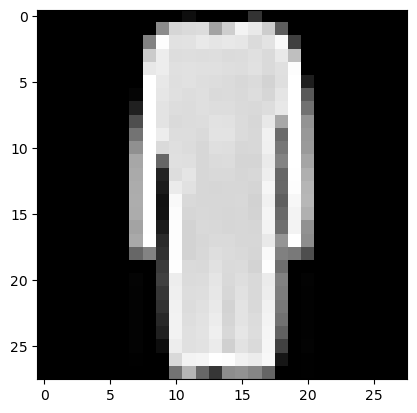

In [119]:
plt.imshow(subj.view(28,28),cmap='gray')

In [120]:
subj=subj.to('cuda')
outm,outstd=encdevice(subj.unsqueeze(0))

In [121]:
outm

tensor([[ 1.7051, -0.3302,  0.7275, -1.0942,  0.9311, -0.5975, -0.3154, -0.2430,
         -1.3774,  0.2949]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [122]:
outstd

tensor([[-3.9874, -3.1703, -2.3040, -3.5626, -3.5952, -4.7310, -3.4388, -3.5412,
         -3.0288, -3.1590]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [123]:
final=decdevice(outm,outstd)

In [124]:
final.shape

torch.Size([1, 784])

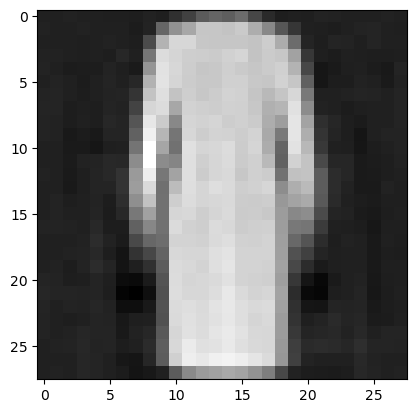

In [125]:
rep=final.to('cpu')
plt.imshow(rep.view(28,28).detach(),cmap='gray')